# Aprroches non supervisées


In [1]:
# Import Python libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import re
import nltk
import time
import spacy
import logging
import gensim
import gensim.corpora as corpora
import multiprocessing
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import gensim
from gensim.models import TfidfModel
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from gensim.models import CoherenceModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display, HTML

C:\Users\Belal ABDOUHOU\anaconda3\envs\env_prj_5\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [5]:
pyLDAvis.enable_notebook()
%matplotlib inline
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

In [6]:
df = pd.read_csv("../clean_table_data.csv")

In [7]:
df = df.astype(str)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36718 entries, 0 to 36717
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       36718 non-null  object
 1   Body        36718 non-null  object
 2   Tags        36718 non-null  object
 3   corp        36718 non-null  object
 4   corp_clean  36718 non-null  object
 5   most_tags   36718 non-null  object
dtypes: object(6)
memory usage: 1.7+ MB


## LDA - Latent Dirichlet Allocation

Le modèle Latent Dirichlet Allocation (LDA) est un modèle probabiliste génératif qui peut être utilisé pour décrire des collections de documents texte ou d'autres types de données discrets. LDA appartient à une catégorie de modèles dit "topic models" qui tentent de découvrir des structures thématiques cachées.

Les paramètres LDA sont estimés en estimant les distributions des variables latentes à partir des données observées. Mathématiquement, LDA peut être considérée comme une technique pour maximiser la log-vraisemblance à l'aide d'un algorithme de maximisation des attentes dans un modèle de mélange.

Elle consiste à transformer la matrice sparse comprenant les termes utilisés dans l'ensemble document en deux matrices :

Une matrice document-sujet qui permet de renseigner sur la présence d’un sujet dans un document
Une matrice sujet-mots qui permet de renseigner sur la présence d’un mot dans un sujet

In [9]:
split_corp = [corp.split() for corp in df['corp_clean']]
# Create a corpus from a list of texts
common_dictionary = corpora.Dictionary(split_corp)
common_dictionary.filter_extremes(no_below=1000)
common_corpus = [common_dictionary.doc2bow(text) for text in split_corp]
tfidf = TfidfModel(common_corpus)
tfidf_corpus = [tfidf[text] for text in common_corpus]

In [10]:
# Finding the best number of topic
number_list = [i for i in range(2, 51)]
# Calculate coherence test
coherence_test = []
for k in number_list:
    print("K = {}".format(k))
    model_lda = LdaMulticore(corpus=common_corpus,
                             id2word=common_dictionary,
                             num_topics=k,
                             passes=10,
                             random_state=42,
                             workers=7)
    coherence_model_lda = CoherenceModel(model=model_lda,
                                         texts=split_corp,
                                         dictionary=common_dictionary,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_test.append((k, coherence_lda))

K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9
K = 10
K = 11
K = 12
K = 13
K = 14
K = 15
K = 16
K = 17
K = 18
K = 19
K = 20
K = 21
K = 22
K = 23
K = 24
K = 25
K = 26
K = 27
K = 28
K = 29
K = 30
K = 31
K = 32
K = 33
K = 34
K = 35
K = 36
K = 37
K = 38
K = 39
K = 40
K = 41
K = 42
K = 43
K = 44
K = 45
K = 46
K = 47
K = 48
K = 49
K = 50


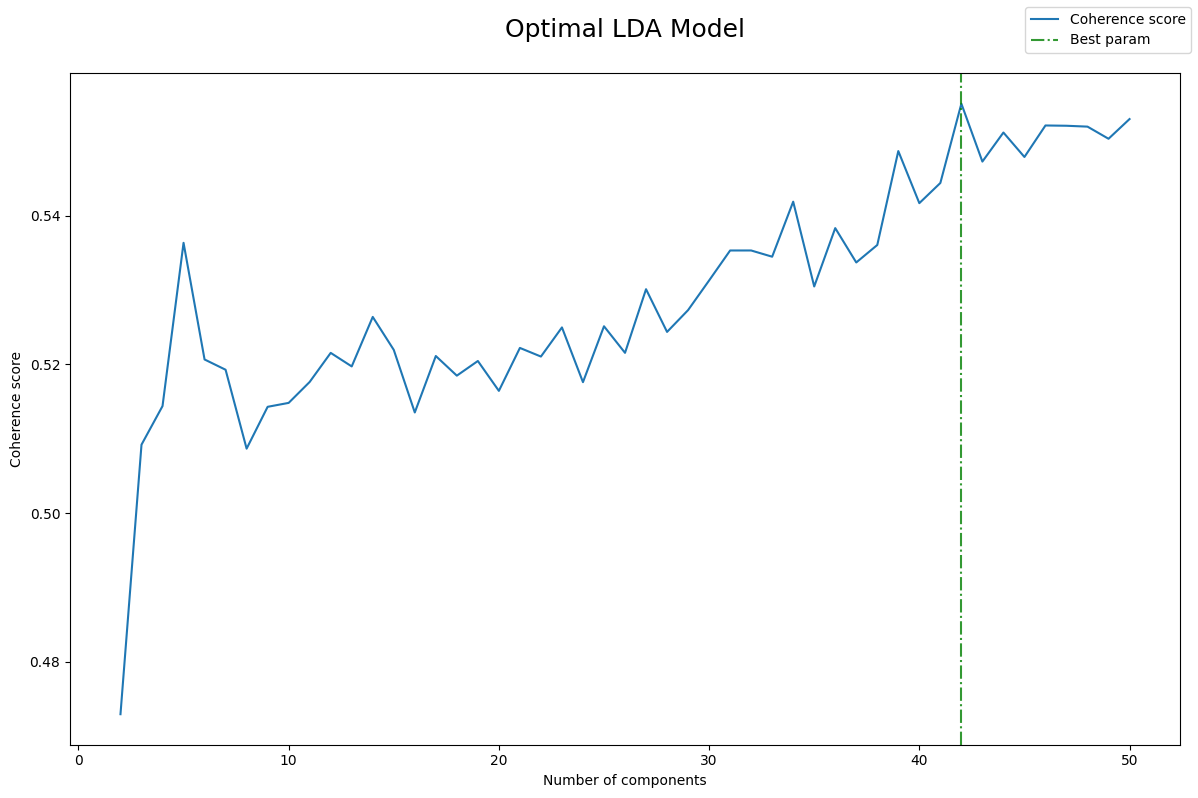

In [11]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence"])

# Select best number of topics
best_nb_topics = coherence_test\
.loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y = coherence_test["coherence"]

ax.plot(x, y, label="Coherence score")
ax.axvline(x=best_nb_topics, color='g', alpha=.8,
           linestyle='dashdot', label='Best param')
ax.set_xlabel("Number of components")
ax.set_ylabel("Coherence score")
# Title
plt.title("Optimal LDA Model\n", fontsize=18)
legend = fig.legend()

fig.tight_layout()
plt.show()

In [12]:
# Best LDA visualization
# Construire le modèle LDA
best_lda_model = LdaMulticore(corpus=common_corpus,
                              id2word=common_dictionary,
                              num_topics=best_nb_topics,
                              per_word_topics=True,
                              passes=10,
                              workers=7)

In [13]:
gensimvis.prepare(best_lda_model, tfidf_corpus, common_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13     0.019209  0.103511       1        1  4.230950
9     -0.206752  0.024376       2        1  4.106860
33    -0.077142  0.122278       3        1  3.447617
17     0.136178  0.022618       4        1  3.262593
32     0.172129 -0.019899       5        1  3.168904
20    -0.240580  0.035442       6        1  3.132843
10    -0.111827  0.110243       7        1  3.060301
30     0.031651 -0.139825       8        1  3.052149
40     0.019904  0.053267       9        1  2.985822
15     0.012230 -0.207417      10        1  2.878722
16     0.063083  0.035812      11        1  2.746118
0     -0.111651  0.022995      12        1  2.661160
6     -0.260992 -0.109697      13        1  2.578052
23    -0.234834 -0.001752      14        1  2.543865
34    -0.011389 -0.025564      15        1  2.535507
8      0.156192  0.006598      16        1  2.445468
19     0.076476  0.055830      17        1  2.429705
28    -0.049443  0.092427      18        1  2.373841
3      0.121088  0.061884      19        1  2.284829
18     0.126175  0.004121      20        1  2.276957
1      0.137874 -0.072133      21        1  2.255388
12     0.022748  0.092959      22        1  2.232267
38     0.038435 -0.235913      23        1  2.214740
31     0.044225  0.156155      24        1  2.176490
26    -0.057191 -0.188095      25        1  2.122272
21    -0.203720 -0.013714      26        1  2.105109
22    -0.000201  0.135505      27        1  2.078412
14     0.093717 -0.171047      28        1  2.074904
29    -0.008212  0.072949      29        1  1.969632
39    -0.053791  0.028688      30        1  1.946498
11    -0.020648  0.068843      31        1  1.939272
36     0.079616  0.116019      32        1  1.918533
4      0.049973 -0.094153      33        1  1.895232
5      0.105614  0.003580      34        1  1.885769
27    -0.133864 -0.149230      35        1  1.875362
37    -0.061657 -0.042191      36        1  1.864714
7      0.110704 -0.119752      37        1  1.704605
41     0.034655  0.026803      38        1  1.648497
25     0.124971  0.091628      39        1  1.582223
24     0.069954 -0.048452      40        1  1.518329
2     -0.038743  0.116933      41        1  1.445559
35     0.035841 -0.022625      42        1  1.343931, topic_info=           Term         Freq        Total Category  logprob  loglift
41         file  1996.000000  1996.000000  Default  30.0000  30.0000
94         data  1278.000000  1278.000000  Default  29.0000  29.0000
2          type  1095.000000  1095.000000  Default  28.0000  28.0000
56     function  1190.000000  1190.000000  Default  27.0000  27.0000
32        value  1159.000000  1159.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
14          way    11.498987  1397.158610  Topic42  -4.6409  -0.4904
45        class    12.234478  1527.396567  Topic42  -4.5789  -0.5175
16  application     6.708598  1160.291107  Topic42  -5.1798  -0.8435
73        error     6.555121  1615.147906  Topic42  -5.2029  -1.1974
86     question     5.010046   844.837125  Topic42  -5.4717  -0.8181

[1528 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
71        2  0.002982  access
71        3  0.017889  access
71        4  0.014908  access
71        5  0.005963  access
71        6  0.059630  access
...     ...       ...     ...
44       10  0.002396     xml
44       28  0.876950     xml
44       33  0.110218     xml
44       35  0.002396     xml
44       36  0.002396     xml

[3493 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 10, 34, 18, 33, 21, 11, 31, 41, 16, 17, 1, 7, 24, 35, 9, 20, 29, 4, 19, 2, 13, 39, 32, 27, 22, 23, 15, 30, 40, 12, 37, 5, 6, 28, 38, 8, 42, 26, 25, 3, 36])

In [14]:
joblib.dump(common_corpus, open("../Variables/common_corpus.joblib", 'wb'), compress=True)
joblib.dump(common_dictionary, open("../Variables/common_dictionary.joblib", 'wb'), compress=True)
joblib.dump(best_lda_model, open("../Models/LDA_model.joblib", 'wb'), compress=True)

### NMF - Non-negative Matrix Factorization

La factorisation matricielle non négative, ou NMF, est une méthode permettant de factoriser une matrice non négative X dans le produit de deux matrices de rang inférieur, A et B, de sorte que AB se rapproche d'une solution optimale de X. Cette technique est principalement utilisée dans les systèmes de recommandation, les applications de fouille de texte et d'analyse d'images. 

NMF est un algorithme d'extraction de caractéristiques de pointe utile lorsque de nombreuses caractéristiques sont ambiguës et ont un faible pouvoir prédictif. Il peut générer des modèles, des thèmes et des questions significatifs.

In [15]:
def plot_top_words(model, feature_names, 
                   n_top_words, nb_topic_plot, title):
    """Function for displaying the plots of the 
    best x words representative of the categories of NMF.

    Parameters
    ----------------------------------------
    model : NMF model
        Fitted model of NMF to plot
    feature_names : array
        Categories result of the vectorizer (TFIDF ...)
    n_top_words : int
        Number of words for each topic.
    title : string
        Title of the plot.
    ----------------------------------------
    """
    rows = int(nb_topic_plot/4)
    fig, axes = plt.subplots(rows, 4, 
                             figsize=(30, rows*10), 
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_topic_plot):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [16]:
X_train_tfidf = joblib.load('../Variables/X_train_tfidf.joblib')
tfidf = joblib.load('../Models/tfidf_vectorizer.joblib')

--------------------------------------------------
Start NMF fitting on Doc ...
--------------------------------------------------
End of training :
Execution time : 17.91s
--------------------------------------------------


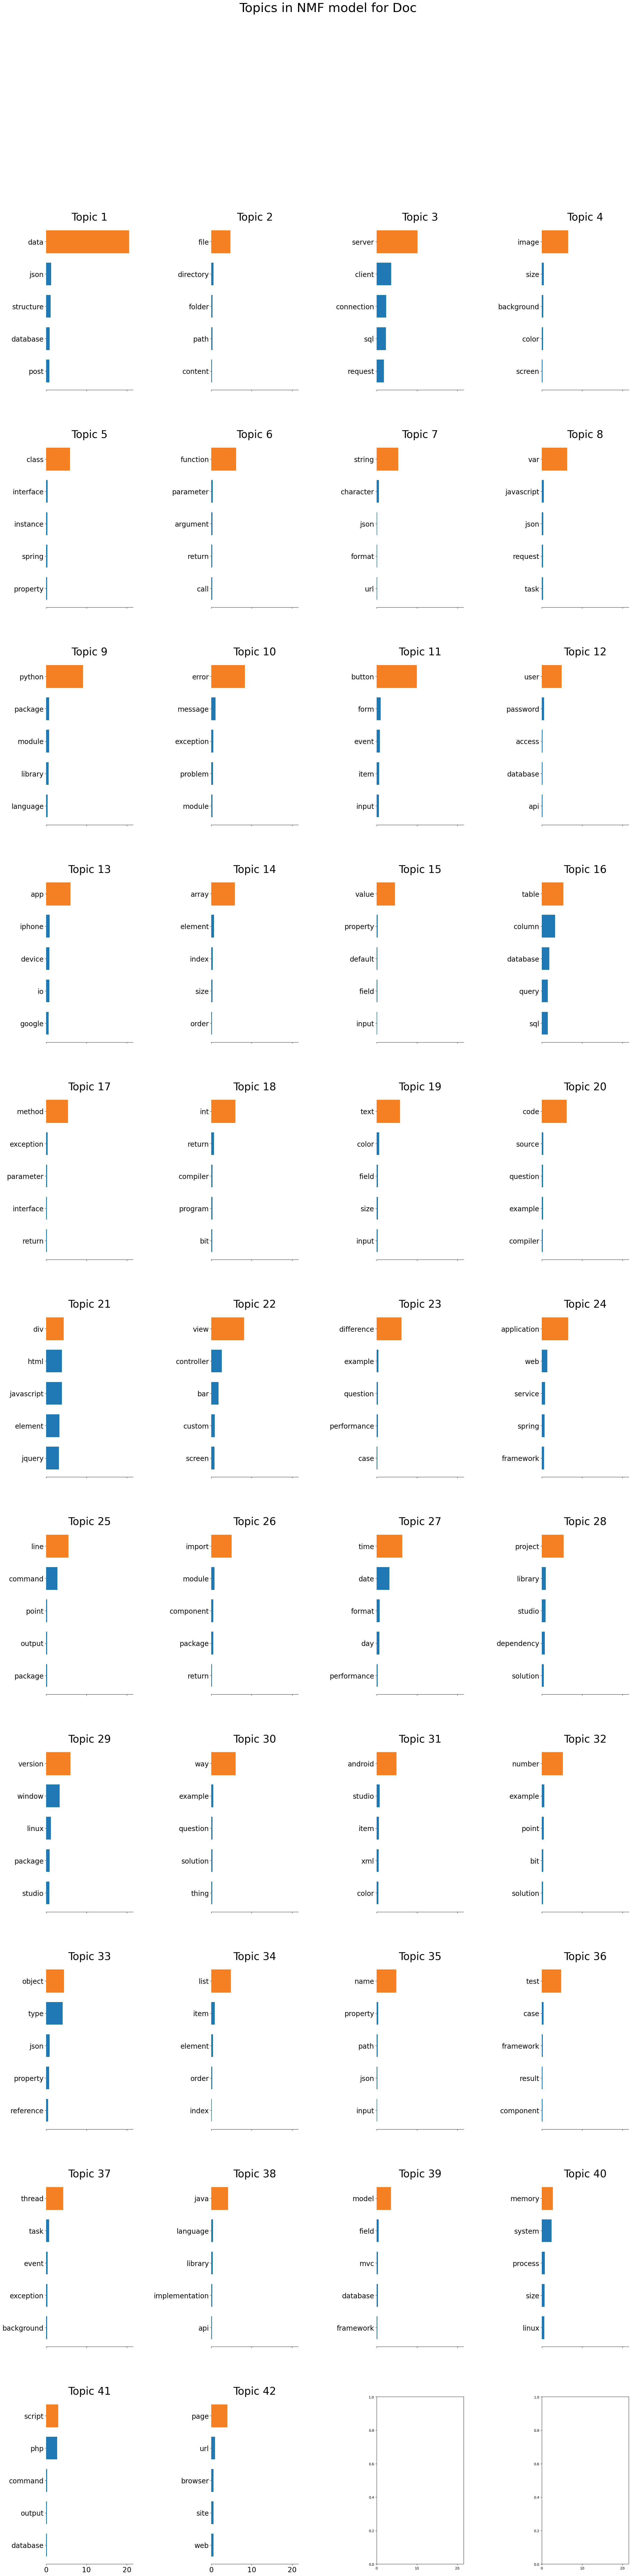

In [17]:
## Define number of topics to test
n_topics = best_nb_topics

print("-"*50)
print("Start NMF fitting on Doc ...")
print("-" * 50)
start_time = time.time()
# Initializing the NMF
full_nmf = NMF(n_components=n_topics,
               init='nndsvd',
               random_state=42)

# Fit NMF on Body vectorized
full_nmf.fit(X_train_tfidf)

exec_time = time.time() - start_time
print("End of training :")
print("Execution time : {:.2f}s".format(exec_time))
print("-" * 50)

# Plot the 18 first topics
ff_feature_names = tfidf.get_feature_names_out()
plot_top_words(full_nmf, ff_feature_names, 5, 4*(best_nb_topics//4 + 1),
               'Topics in NMF model for Doc')

In [18]:
joblib.dump(full_nmf, open("../Models/NMF_model.joblib", 'wb'), compress=True)